In [21]:
!pip install torcheval # Needed for Kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.3 MB/s eta 0:00:00a 0:00:01


### Team Paradox: Alisher Omarbekov, Dias Rysbekov; Ballroom Left

#### This notebook was run in Kaggle. The dataset was uploaded manually to the notebook, as adding data through the competition did not work. A small change was made to the file structure of the dataset to allow for easier data loading: all the train data classes 0 to 4 was put in the train folder and extra techosmotr folder was removed to shorten the path, so the structure became '/kaggle/input/case3-changed/case3-datasaur-photo-changed/techosmotr/train', where the 'train' folder contained subfolders for all 5 classes.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import PIL
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torch.utils.data import Subset
from torchvision import models
from torcheval.metrics.functional import multiclass_f1_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### For transformations, only a slight change of brightness and contrast for some samples is applied, since more significant alterations may severely affect the accuracy, as incorrect images can differ only slightly and their difference may be through noise due to taking a picture of a display or using photoshop. Normalization used here is an average for all train images.

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize for EfficientNetV2. Can be larger, but GPU memory is limited
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2)], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4544, 0.4599, 0.4674], std=[0.2864, 0.2845, 0.2873])
])

In [ ]:
# Where to load train images from
data_dir = '/kaggle/input/case3-changed/case3-datasaur-photo-changed/techosmotr/train'

In [3]:
# Since ImageFolder is used, the train directory must have folders for each class
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

#### Custom subset class was created in order to make the train-test split of the data easier and allow for correct weighted sampling, as unfortunately the default subset class does inherits targets from ImageFolder and does not have targets specific to its inputs.

In [4]:
class CustomSubset(torch.utils.data.Dataset):
    r"""
    Subset of a dataset at specified indices.

    Arguments:
        dataset (Dataset): Initial dataset
        indices (sequence): Indices selected for creation of this subset
        labels(sequence) : Target values at the selected indices; same length as indices
    """
    def __init__(self, dataset, indices, labels):
        self.dataset = torch.utils.data.Subset(dataset, indices)
        self.targets = labels
    def __getitem__(self, idx):
        image = self.dataset[idx][0]
        target = self.targets[idx]
        return (image, target)

    def __len__(self):
        return len(self.targets)

In [5]:
train_proportion = 0.8 # What part of images to use as train samples

indices = list(range(len(dataset)))
np.random.shuffle(indices) # Assure randomness

train_size = int(train_proportion * len(dataset))
test_size = len(dataset) - train_size

train_indices = indices[:train_size]
test_indices = indices[test_size:]

# np.take() is used to provide the target values specific to the selected indices to CustomSubset
train_dataset = CustomSubset(dataset, train_indices, np.take(dataset.targets, train_indices))
test_dataset = CustomSubset(dataset, test_indices, np.take(dataset.targets, test_indices))
print(np.take(dataset.targets, train_indices).size)

5268


In [6]:
labels = train_dataset.targets # Our training set labels
print(np.sum(labels == 3)) # Just a check to assure that a class is present

3610


#### In order to combat class imbalance (there are not many incorrect images), we use WeightedRandomSampler, which batches data according to its weight and tries to oversample the rarer samples.

In [7]:
class_weights = 1 / np.bincount(labels)

# Create a custom sampler with weights
sample_weights = np.array([class_weights[label] for label in labels])
sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))
len(sample_weights)

5268

In [ ]:
batch_size = 64

In [8]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          sampler=sampler)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

#### Just a peek into a batch from trainloader. Thanks to the weighted sampler, all classes are represented.

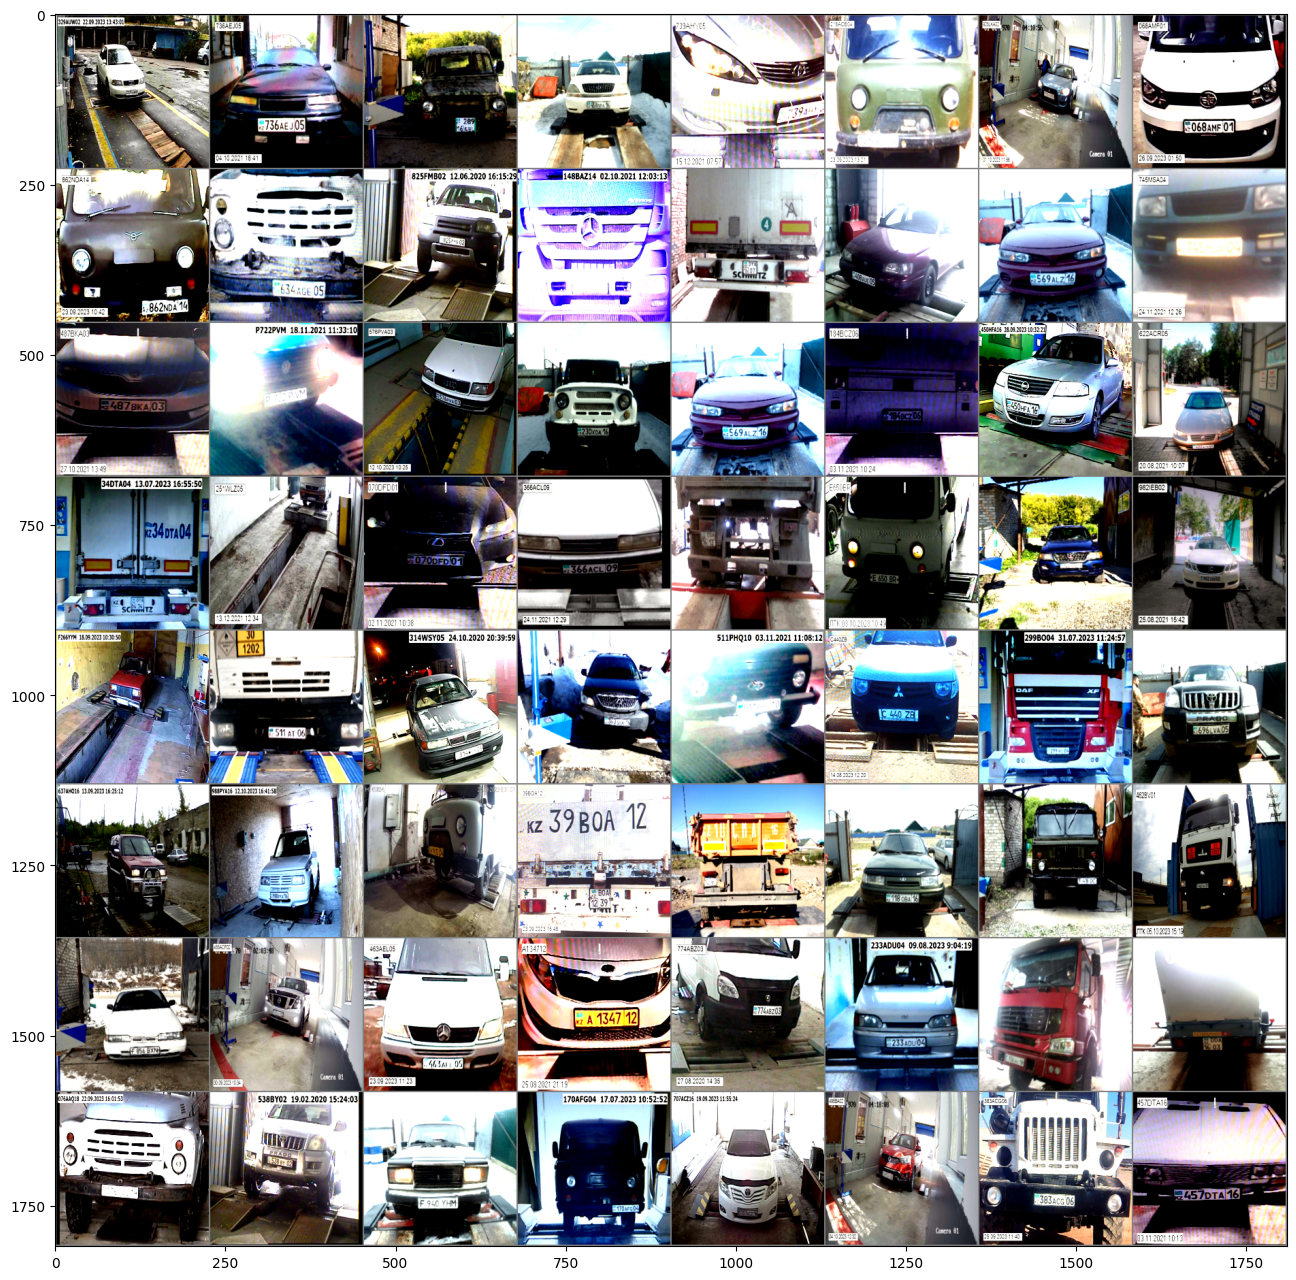

0-correct 4-photoshop 4-photoshop 0-correct 3-from-the-screen+photoshop 2-from-the-screen 0-correct 2-from-the-screen 2-from-the-screen 3-from-the-screen+photoshop 1-not-on-the-brake-stand 2-from-the-screen 2-from-the-screen 0-correct 4-photoshop 3-from-the-screen+photoshop 3-from-the-screen+photoshop 1-not-on-the-brake-stand 0-correct 1-not-on-the-brake-stand 4-photoshop 3-from-the-screen+photoshop 0-correct 3-from-the-screen+photoshop 2-from-the-screen 1-not-on-the-brake-stand 3-from-the-screen+photoshop 3-from-the-screen+photoshop 2-from-the-screen 0-correct 4-photoshop 3-from-the-screen+photoshop 0-correct 3-from-the-screen+photoshop 1-not-on-the-brake-stand 4-photoshop 1-not-on-the-brake-stand 4-photoshop 2-from-the-screen 4-photoshop 0-correct 0-correct 0-correct 2-from-the-screen 1-not-on-the-brake-stand 0-correct 1-not-on-the-brake-stand 0-correct 4-photoshop 0-correct 2-from-the-screen 3-from-the-screen+photoshop 1-not-on-the-brake-stand 2-from-the-screen 4-photoshop 4-photosh

In [82]:
classes = [
    'Correct',
    'Brake stand',
    'Screen',
    'S+P',
    'Photoshop'
]
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)  

f = plt.figure(figsize=(16, 16))

imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


#### We use the EfficientNetV2 model (https://arxiv.org/abs/2104.00298) published in 2021 and which shows top performance at various datasets, trains relatively fast and has a reasonable number of parameters - specifically the small variant available in PyTorch

In [15]:
num_classes = 5

effnet_model = models.efficientnet_v2_s(pretrained=True) # Import the weights

# Freeze the layers
for param in effnet_model.parameters():
    param.requires_grad = False

# Replace the classifier layer by changing the output number to the number of classes we have
effnet_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(effnet_model.classifier[1].in_features, num_classes))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
effnet_model.to(device)
print(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 269MB/s]


cuda


#### Using a higher learning rate than if we were training the model from scratch (3e-4)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(effnet_model.parameters(), lr=0.001) 

#### Lists to store the accuracy and loss

In [17]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

In [ ]:
epochs = 50

In [18]:
passed_epochs = 0
for epoch in range(epochs):
    effnet_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = effnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(trainloader)
    avg_train_accuracy = 100 * correct_train / total_train
    train_loss.append(avg_train_loss)
    train_acc.append(avg_train_accuracy)
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.2f}%")

    effnet_model.eval()

    running_test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = effnet_model(images)
            loss = criterion(outputs, labels)

            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    avg_test_loss = running_test_loss / len(testloader)
    avg_test_accuracy = 100 * correct_test / total_test

    test_loss.append(avg_test_loss)
    test_acc.append(avg_test_accuracy)

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.2f}%")
    passed_epochs += 1

Epoch 1, Training Loss: 1.2491, Training Accuracy: 54.63%
Test Loss: 0.9780, Test Accuracy: 67.88%
Epoch 2, Training Loss: 0.9425, Training Accuracy: 68.36%
Test Loss: 0.8260, Test Accuracy: 73.22%
Epoch 3, Training Loss: 0.8525, Training Accuracy: 71.20%
Test Loss: 0.7689, Test Accuracy: 75.00%
Epoch 4, Training Loss: 0.8029, Training Accuracy: 73.16%
Test Loss: 0.7025, Test Accuracy: 76.86%
Epoch 5, Training Loss: 0.7429, Training Accuracy: 74.79%
Test Loss: 0.7037, Test Accuracy: 76.82%
Epoch 6, Training Loss: 0.7053, Training Accuracy: 76.59%
Test Loss: 0.7193, Test Accuracy: 75.85%
Epoch 7, Training Loss: 0.6945, Training Accuracy: 76.01%
Test Loss: 0.6747, Test Accuracy: 77.05%
Epoch 8, Training Loss: 0.6746, Training Accuracy: 76.94%
Test Loss: 0.6528, Test Accuracy: 77.90%
Epoch 9, Training Loss: 0.6528, Training Accuracy: 77.81%
Test Loss: 0.6611, Test Accuracy: 78.02%
Epoch 10, Training Loss: 0.6463, Training Accuracy: 77.79%
Test Loss: 0.6042, Test Accuracy: 80.13%
Epoch 11,

KeyboardInterrupt: 

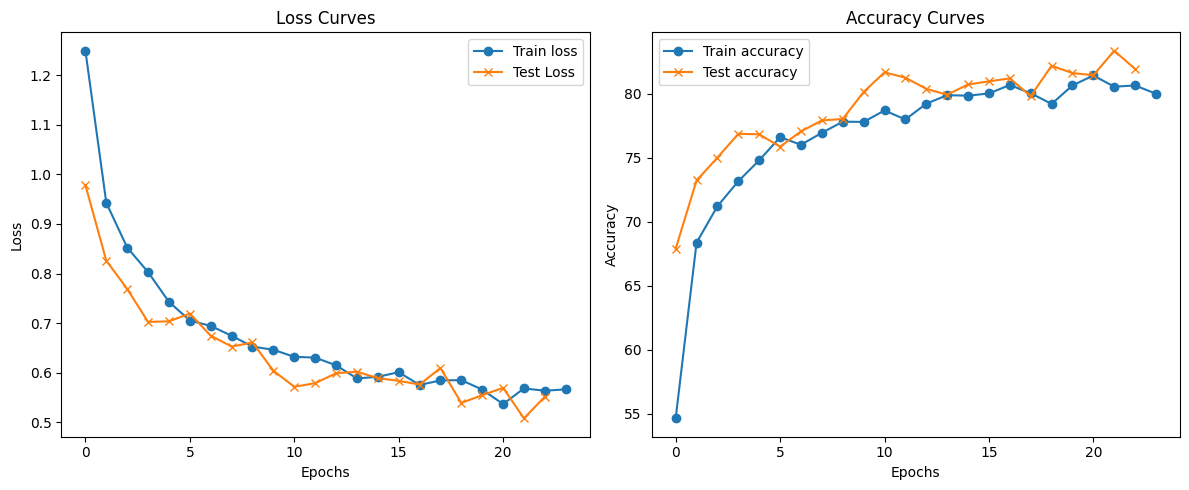

In [21]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)

# If an error appears, perhaps the training was interrupted and range for test is 1 less than for train.
plt.plot(range(passed_epochs), train_loss, label='Train loss', marker='o')
plt.plot(range(passed_epochs), test_loss, label='Test Loss', marker='x')


plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(range(passed_epochs), train_acc, label='Train accuracy', marker='o')
plt.plot(range(passed_epochs), test_acc, label='Test accuracy', marker='x')


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.tight_layout()
plt.show()

#### This function is used to save predictions for each image filename and save them to a dictionary.

In [48]:
def prediction(img_path, transform, model):
    model.eval()
    image = PIL.Image.open(img_path).convert('RGB')
    image_tensor = transform(image)
    image_tensor = image_tensor.unsqueeze(0) #so img is not treated as a batch

    with torch.no_grad():
        output = model(image_tensor.to(device))
        _, pred = torch.max(output.data, 1)
    return pred.item()

In [77]:
preds = {

}
image_dir = '/content/case3/techosmotr/techosmotr/test'
for filename in os.listdir(image_dir):
    image_path = os.path.join(image_dir, filename)
    res = prediction(image_path, transform, effnet_model)
    #print(res)
    filename = filename.rsplit('.', 1)[0]
    if res != 0: # All non-zero labels are changed to 1 for the submission
        res = 1
    preds[filename] = res

In [83]:
df = pd.DataFrame(preds.items(), columns=['file_index', 'class'])

# Export the DataFrame to a CSV file
df.to_csv('res.csv', index=False)

In [22]:
torch.save(effnet_model.state_dict(), 'effnet_1_1.pth')

#### Here begins the fine-tuning of the model.

In [72]:
# Clearing the gpu memory in Kaggle
import gc
gc.collect()
torch.cuda.empty_cache()

#### Code below reloads the EfficientNet and loads the required state_dict as the session was not run continiously. If run locally, skip and just unfreeze the layers.

In [9]:
num_classes = 5

effnet_model = models.efficientnet_v2_s(pretrained=True)

effnet_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(effnet_model.classifier[1].in_features, num_classes))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

effnet_model.load_state_dict(torch.load('/kaggle/input/effnet2-2/effnet_2_2.pth'))

effnet_model.to(device)
print(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 206MB/s] 


cuda


In [11]:
for param in effnet_model.parameters():
    param.requires_grad = True # Now training all layers

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(effnet_model.parameters(), lr=3e-5) # much lower lr for fine-tuning

In [ ]:
batch_size = 64 # adjust according to your GPU
epochs = 10

In [53]:
ft_test_loss = []
ft_train_loss = []
ft_test_acc = []
ft_train_acc = []
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          sampler=sampler)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

#### These lists are for the confusion matrix.

In [ ]:
y_true = []
y_pred = []

In [87]:
passed_epochs = 0
for epoch in range(epochs):
    effnet_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = effnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(trainloader)
    avg_train_accuracy = 100 * correct_train / total_train
    ft_train_loss.append(avg_train_loss)
    ft_train_acc.append(avg_train_accuracy)
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.2f}%")

    effnet_model.eval()

    running_test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = effnet_model(images)
            loss = criterion(outputs, labels)

            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())        

    conf_mat = confusion_matrix(y_true, y_pred)

    avg_test_loss = running_test_loss / len(testloader)
    avg_test_accuracy = 100 * correct_test / total_test

    ft_test_loss.append(avg_test_loss)
    ft_test_acc.append(avg_test_accuracy)

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.2f}%")
    passed_epochs += 1

Epoch 1, Training Loss: 0.0136, Training Accuracy: 99.68%
Test Loss: 0.0335, Test Accuracy: 99.28%
Epoch 2, Training Loss: 0.0135, Training Accuracy: 99.64%
Test Loss: 0.0310, Test Accuracy: 99.32%


KeyboardInterrupt: 

#### Quickly check the f1-score of our model

In [24]:
multiclass_f1_score(predicted, labels, num_classes=num_classes)

tensor(1., device='cuda:0')

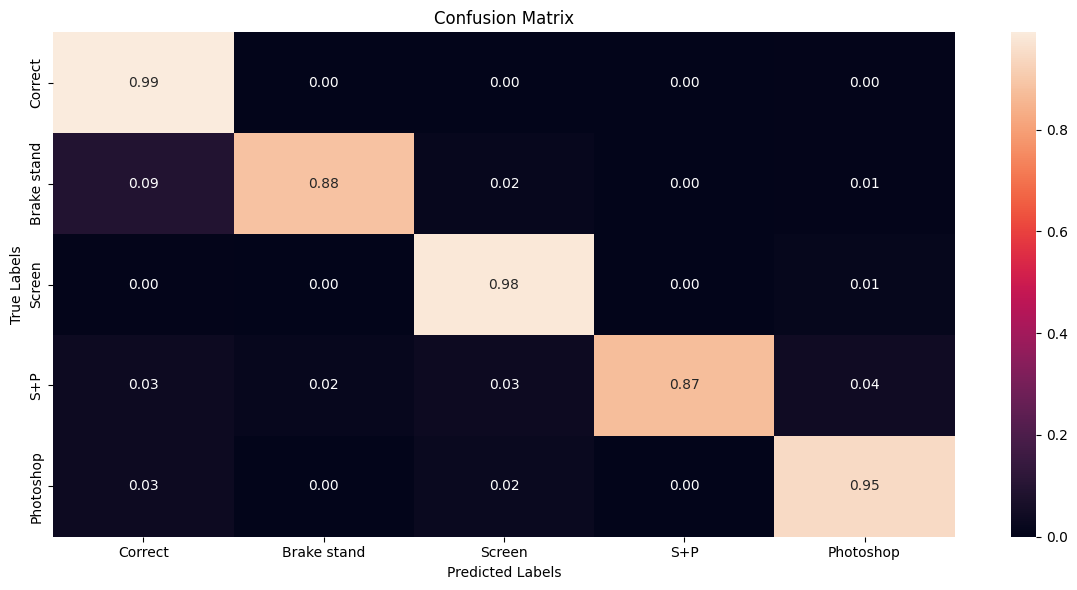

In [19]:
classes = [
    'Correct',
    'Brake stand',
    'Screen',
    'S+P',
    'Photoshop'
] 

conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 1, figsize=(12, 6))

sns.heatmap(conf_mat, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, ax=axes)
axes.set_xlabel('Predicted Labels')
axes.set_ylabel('True Labels')
axes.set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

#### The model may sometimes classify images where the car is not on a brake stand as correct ones. Manual inspection of the dataset shows that some of the images are incorrectly labeled as such, or it is really difficult to tell. However, the results are really great considering the class imbalance and image differences in quality.

In [88]:
torch.save(effnet_model.state_dict(), 'effnet_2_5.pth')

#### Again run on test folder and save in csv. Could have been a function, but no need in Kaggle, easy to change later

In [89]:
preds = {

}
image_dir = '/kaggle/input/case3-changed/case3-datasaur-photo-changed/techosmotr/test'
for filename in os.listdir(image_dir):
    image_path = os.path.join(image_dir, filename)
    res = prediction(image_path, transform, effnet_model)
    #print(res)
    filename = filename.rsplit('.', 1)[0]
    if res != 0:
        res = 1
    preds[filename] = res

In [90]:
df = pd.DataFrame(preds.items(), columns=['file_index', 'class'])

# Export the DataFrame to a CSV file
df.to_csv('res6.csv', index=False)